# Workforce and statistics

Using fictional workforce numbers data, and using a variety of statistics and machine learning to investigate the dataset.

In [1]:
# load required libraries
import pandas as pd
import numpy as np
import re
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error # for regression
from sklearn.metrics import roc_curve, auc # for classification
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["font.family"] = "Cambria" # this sets the font type to use for any matplotlib graphs

Next, invent some data

In [2]:
# create some data
wrkforce_nbrs = [10,15,12,25,24,26,13,20,25,23,24,17]
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

# make a df of this
wkfrce = pd.DataFrame({'nbrs':wrkforce_nbrs, 'months':months})

From this data, add in additional columns

In [3]:
# get change in nbrs
wkfrce['change'] = wkfrce['nbrs'] - wkfrce['nbrs'].shift(1)#, fill_value=0)
wkfrce[['change']] = wkfrce[['change']].fillna(value=0)

# Make a hypothesis to test for and test it

quick hypothesis test:
null hypothesis h0: there is no relationship between workers joining and the workforce numbers
alternative hypothesis h1: there is a relationship between workers joining and the workforce numbers

In [4]:
wkfrce['category_vals'] = wkfrce['change'].apply(lambda x: 1 if x > 0 else 0)
acceptance_criteria = 0.05

promo_results = wkfrce[wkfrce['category_vals'] == 1]['category_vals']
standard_results = wkfrce[wkfrce['category_vals'] == 0]['category_vals']

n_con = promo_results.count()
n_treat = standard_results.count()
successes = [promo_results.sum(), standard_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

if pval <= acceptance_criteria:
    print("The p-value is at or below the acceptance criteria. You can reject the null hypothesis.")
else:
    print("The p-value is above the acceptance criteria. You can not reject the null hypothesis, you have to accept the null hypothesis.")

pval

The p-value is at or below the acceptance criteria. You can reject the null hypothesis.


0.0005320055051392492

# Model the data with statistics and machine learning

Define functions to use in the code below

In [5]:
def basic_line_graph(x,y,xlab,ylab,title):
    fig, ax = plt.subplots()
    
    ax.plot(x,y,color='#CD2456')
    #ax.set_ylim(0,1)
    #ax.set_yticks(np.arange(0, 1.1, 0.1))
    #ax.set_xticks(np.arange(0.05, 0.85, 0.1))
    #ax.set_xticklabels(band_lst, rotation='horizontal',size=8)
    ax.set_ylabel(ylab, size=10)
    ax.set_xlabel(xlab, size=10)
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_axisbelow(True) # to put gridlines at back
    ax.grid(linestyle='--', color='#CECECE')
    
    # save plot
    # set size of graph
    cmsize = 1/2.54
    fig.set_size_inches(30*cmsize, 15*cmsize)
    
def basic_scatter_graph(x,xvals,y,z,xlab,ylab,title):
    fig, ax = plt.subplots()
    
    scatter_points = ["^","s","+","x"]
    
    for types in range(0,len(z.unique()),1):
        ax.scatter(x[z==z.unique()[types]],y[z==z.unique()[types]],color='#CD2456', marker=scatter_points[types], label=z.unique()[types])
        #ax.scatter(x[z==z.unique()[types]],y[z==z.unique()[types]],color='#'+str(hex(random.randint(0,16777215)))[2:], marker=scatter_points[types], label=z.unique()[types])
    #ax.set_ylim(0,1)
    #ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_xticks(x)
    ax.set_xticklabels(xvals, rotation='horizontal',size=8)
    ax.set_ylabel(ylab, size=10)
    ax.set_xlabel(xlab, size=10)
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.set_axisbelow(True) # to put gridlines at back
    #ax.grid(linestyle='--', color='#CECECE')
    ax.legend(loc='upper left',fontsize=8)
    
    # save plot
    # set size of graph
    cmsize = 1/2.54
    fig.set_size_inches(30*cmsize, 15*cmsize)
    
def mape_value (true_value, predictions):
    return np.mean(np.abs((predictions - true_value) / true_value)) * 100

def mae (true_value, predictions):
    return np.mean(np.abs((predictions - true_value)))

def mse(true_value, predictions):
    return (((predictions - true_value) ** 2).mean())

def rmse(true_value, predictions):
    return np.sqrt(((predictions - true_value) ** 2).mean())

def train_test_graph_error_lines(x,y1,y2,mae,xlab,ylab,title,predlab):
    # Initialise a figure. subplots() with no args gives one plot.
    fig, ax = plt.subplots()

    # Plot each bar plot. Note: manually calculating the 'dodges' of the bars
    #ax = plt.axes()

    #ax.plot(range(0,len(x),1), y1, label='Real', color='#CD2456')
    #ax.plot(range(0,len(x),1), y2, label=predlab, color='#14022E')
    ax.plot(x, y1, label='Real', color='#CD2456')
    ax.plot(x, y2, label=predlab, color='#14022E')
    ax.fill_between(range(0,len(x),1),y2-mae,y2+mae,alpha=0.2)

    # Customise some display properties for line graph
    ax.set_ylabel('',size=8)
    #ax.set_ylim(0,200)
    #ax.set_xlim(0,8)
    ax.set_xlabel('',size=8)
    ax.set_title(title,size=9)
    ax.set_xticks(range(0,len(x),1))    # This ensures we have one tick per year, otherwise we get fewer
    #ax.set_xticklabels(range(0,len(x),1), rotation='horizontal',size=8)
    #ax.fill(df.Doy[df.Product=='A'],df.Sales[df.Product=='A']-5,df.Sales[df.Product=='A']+5,color='k', alpha=.15)
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax.legend(loc='upper left',fontsize=8)
    ax.set_axisbelow(True)
    ax.grid(linestyle='--',color='#CECECE')
    ax.tick_params(axis='y',labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #set size of graph
    cmsize=1/2.54
    fig.set_size_inches(30*cmsize, 15*cmsize)
    
def linear_regression_estimates(x,y1,y2,epochs,xlab,ylab,title,predlab):
    # Initialise a figure. subplots() with no args gives one plot.
    fig, ax = plt.subplots()

    # Plot each bar plot. Note: manually calculating the 'dodges' of the bars
    #ax = plt.axes()

    #ax.plot(range(0,len(x),1), y1, label='Real', color='#CD2456')
    #ax.plot(range(0,len(x),1), y2, label=predlab, color='#14022E')
    #ax.plot(x, y1, label='Real', color='#CD2456')
    #ax.plot(x, y2, label=predlab, color='#14022E')
    
    # for random data make estimates of fit
    x_rand = random.random()
    y_rand = random.random()
    x_rander = np.linspace(0, len(x)-1, epochs)
    slope = mod_slope[0] # this is cheating taking existing model slope
    y_intercept = max(y1)#y1[0] # data point 0
    for epoch in range(epochs):
        ax.plot(x_rander,y_intercept*random.random() + slope*x_rander,label='Potential fits',color='grey')
        
    ax.plot(x, y1, label='Real', color='#CD2456')
    ax.plot(x, y2, label=predlab, color='#14022E')
    
    #ax.fill_between(range(0,len(x),1),y2-mae,y2+mae,alpha=0.2)

    # Customise some display properties for line graph
    ax.set_ylabel('',size=8)
    #ax.set_ylim(0,200)
    #ax.set_xlim(0,8)
    ax.set_xlabel('',size=8)
    ax.set_title(title,size=9)
    ax.set_xticks(range(0,len(x),1))    # This ensures we have one tick per year, otherwise we get fewer
    #ax.set_xticklabels(range(0,len(x),1), rotation='horizontal',size=8)
    #ax.fill(df.Doy[df.Product=='A'],df.Sales[df.Product=='A']-5,df.Sales[df.Product=='A']+5,color='k', alpha=.15)
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax.legend(loc='upper left',fontsize=8)
    ax.legend(*[*zip(*{l:h for h,l in zip(*ax.get_legend_handles_labels())}.items())][::-1]) # remove duplicate entries
    ax.set_axisbelow(True)
    ax.grid(linestyle='--',color='#CECECE')
    ax.tick_params(axis='y',labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #set size of graph
    cmsize=1/2.54
    fig.set_size_inches(30*cmsize, 15*cmsize)
    
def depth_plot(x,y,yvals,labels,title):
    fig, ax = plt.subplots()
    
    ax.scatter(x,y,s=20, edgecolor="black", c="darkorange", label="data")
    
    # plot the ranges of extra data needed
    for ii in range(0, len(yvals), 1):
        ax.plot(np.arange(len(x)),yvals[ii], color='#'+str(hex(random.randint(0,16777215)))[2:], label=labels[ii])
    
    #ax.set_xlabel("data")
    #ax.set_ylabel("target")
    ax.set_title(title)
    ax.legend(loc='upper left',fontsize=8)
    ax.set_axisbelow(True)
    ax.grid(linestyle='--',color='#CECECE')
    ax.tick_params(axis='y',labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #set size of graph
    cmsize=1/2.54
    fig.set_size_inches(30*cmsize, 15*cmsize)
    
#def tree_depth_plot(x,y,yvals,labels,title):
#    fig, ax = plt.subplots()
#    
#    ax.scatter(x,y,s=20, edgecolor="black", c="darkorange", label="data")
#    
#    # plot the ranges of extra data needed
#    for ii in range(0, len(yvals), 1):
#        ax.plot(np.arange(len(x)),yvals[ii], color='#'+str(hex(random.randint(0,16777215)))[2:], label=labels[ii])
#    
#    #ax.set_xlabel("data")
#    #ax.set_ylabel("target")
#    ax.set_title(title)
#    ax.legend(loc='upper left',fontsize=8)
#    ax.spines['top'].set_visible(False)
#    ax.spines['right'].set_visible(False)
#    
#    #set size of graph
#    cmsize=1/2.54
#    fig.set_size_inches(30*cmsize, 15*cmsize)
    
def plot_model(X, y, model, title_extra, fix_margins=False):
# https://stackoverflow.com/questions/63864256/dataframe-contourf-plot-python
# https://stackoverflow.com/questions/24032282/create-contour-plot-from-pandas-groupby-dataframe
# https://stackoverflow.com/questions/19054923/plot-decision-boundary-matplotlib   
    X = np.array(X)#.reshape(-1,1)
    y = np.array(y)#.reshape(-1,1)
    
    #plot_points(X, y)
    basic_scatter_graph(x=wkfrce['xvals'], xvals=wkfrce['months'],y=wkfrce['nbrs'], z=wkfrce['category'], xlab="Months", ylab="Number", title="Decision boundary plot "+title_extra)
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

    # here "model" is your model's prediction (classification) function
    #Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.2, levels=range(-1,2))
    plt.contour(xx, yy, Z,colors = 'k',linewidths = 3)
    #plt.scatter(X[:, 0], X[:, 1])
    plt.show()
    
def plot_multiclass_roc(clf, x, y, n_classes, name_to_use, figsize=(17, 6)):
    y_score = clf.predict_proba(x)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example '+name_to_use)
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = '+str(round(roc_auc[i],2))+') for label: '+class_names[i])
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    #plt.savefig(output_folder+output_extra+name_to_use+'_roc_curves.png', dpi=400, bbox_inches='tight')
    #plt.close()
    #sns.despine()
    plt.show()

# Regression modelling

For regression modelling, the values used need to be numbers not text values

In [6]:
# on the data, make another x-variable which is the range of x-values used
wkfrce['xvals'] = wkfrce.index+1

# alternatively, you can use pandas dummies or create a function to specify which values to use
wkfrcetest = pd.get_dummies(wkfrce['months'])

# from this test dataset, loop through columns and ows to find number and append values to df
vals = []
ids = []
for i in range(0,len(wkfrcetest),1):
    flt = wkfrcetest[wkfrcetest.columns[i]] # get column
    flt = flt[flt==1] # filter to where value is 1
    vals.append(flt.index[0]) # add value as index/row number
    ids.append(flt.name) # add month name

# make a df of these
wkfrcetest1 = pd.DataFrame({'months':ids, 'xvals':vals})

# join onto original df
wkfrce = pd.merge(wkfrce,wkfrcetest1, how="left", left_on="months", right_on="months")

def mnth_nbr(value):
    if value['months'] == "Jan":
        return 1
    elif value['months'] == "Feb":
        return 2
    elif value['months'] == "Mar":
        return 3
    elif value['months'] == "Apr":
        return 4
    elif value['months'] == "May":
        return 5
    elif value['months'] == "Jun":
        return 6
    elif value['months'] == "Jul":
        return 7
    elif value['months'] == "Aug":
        return 8
    elif value['months'] == "Sep":
        return 9
    elif value['months'] == "Oct":
        return 10
    elif value['months'] == "Nov":
        return 11
    elif value['months'] == "Dec":
        return 12
    else:
        return 0

wkfrce['xvals'] = wkfrce.apply(mnth_nbr,axis=1)

# make x and y array of this data
x_arr = wkfrce['xvals'].to_numpy().reshape(-1,1)
y_arr = wkfrce['nbrs'].to_numpy().reshape(-1,1)

# Linear Regression

Fit a model and get predictions.

A linear regression model is of the form y=ax+c

In [7]:
# fit a linear regression model
model = LinearRegression().fit(x_arr,y_arr)

# for linear regression model
r_sq = model.score(x_arr, y_arr)  # model acccuracy, e.g. is x a good predictor of y for this model with its parameters
mod_int = model.intercept_
mod_slope = model.coef_
print(f"coefficient of determination: {r_sq}")

print(f"intercept: {model.intercept_}"+" this means when x = 0 the predicted y-value is this amount")

print(f"slope: {model.coef_}"+" this means the predicted y-value rises by this amount with each change in x")

# predict y-values
y_pred = model.predict(x_arr)

# put these predictions of the wkfrce df
wkfrce['preds'] = y_pred

# find the difference between the predictions and the actuals
wkfrce['var'] = wkfrce['preds'] - wkfrce['nbrs']

coefficient of determination: 0.20781105686766055
intercept: [14.72727273] this means when x = 0 the predicted y-value is this amount
slope: [[0.73426573]] this means the predicted y-value rises by this amount with each change in x


Check and test model and predictions

In [8]:
# get the MAPE
lr_mape1 = mape_value(wkfrce['nbrs'],wkfrce['preds'])
lr_mape = mean_absolute_percentage_error(wkfrce['nbrs'],wkfrce['preds'])*100

# get the MAE
lr_mae1 = mae(wkfrce['nbrs'],wkfrce['preds'])
lr_mae = mean_absolute_error(wkfrce['nbrs'],wkfrce['preds'])

# get the MSE
lr_mse1 = mse(wkfrce['nbrs'],wkfrce['preds'])
lr_mse = mean_squared_error(wkfrce['nbrs'],wkfrce['preds'])

# get the RMSE
lr_rmse1 = rmse(wkfrce['nbrs'],wkfrce['preds'])
lr_rmse = mean_squared_error(wkfrce['nbrs'],wkfrce['preds'], squared = False)

MAPE is Mean absolute percentage error and this measures the average magnitude of error produced by a model, or how far off predictions are on average.

MAE is the mean absolute error, which shows the average of all the errors in a set. An “error” in this context is an uncertainty in a measurement, or the difference between the measured value and true/correct value. 

RMSE is the root mean square error, which measures the average difference between a statistical model's predicted values and the actual values. Mathematically, it is the standard deviation of the residuals. Residuals represent the distance between the regression line and the data points. 

RMSE penalises large errors more than MAE due to the fact that errors are squared initially. MAE returns values that are more interpretable as it is simply the average of absolute error. 

Typically, RMSE is the favoured metric to use on a per-value basis. RMSE is used as a default metric for calculating Loss Function despite being harder to interpret than MAE. The lower value of MAE, MSE (mean squared error), and RMSE implies higher accuracy of a regression model

Plot the data on a graph

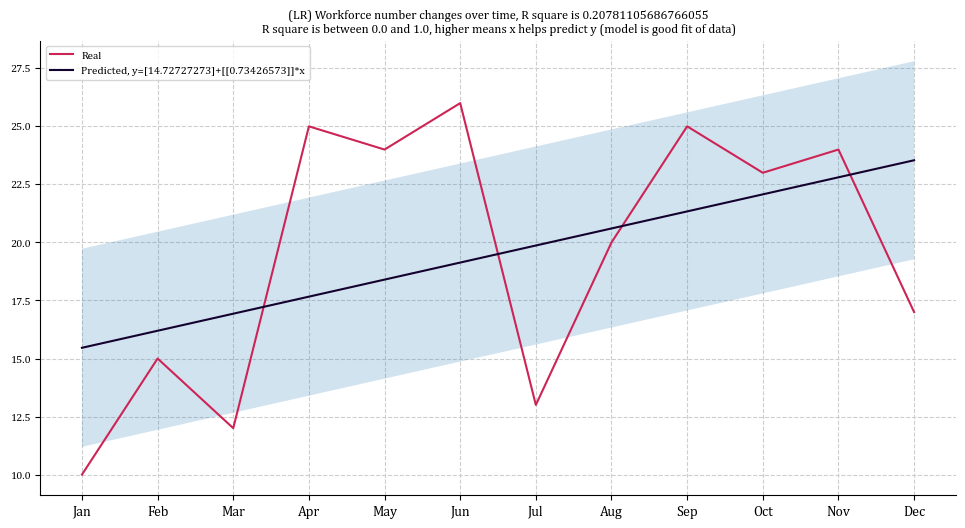

In [9]:
train_test_graph_error_lines(x=wkfrce['months'],y1=wkfrce['nbrs'],y2=wkfrce['preds'],
                             mae=lr_mae,xlab="Months",ylab="Numbers",
                             title=f"(LR) Workforce number changes over time, R square is {r_sq}\n R square is between 0.0 and 1.0, higher means x helps predict y (model is good fit of data)",
                             predlab=f"Predicted, y={mod_int}+{mod_slope}*x")

You can view estimates of the linear regression fit by modelling other data points as below

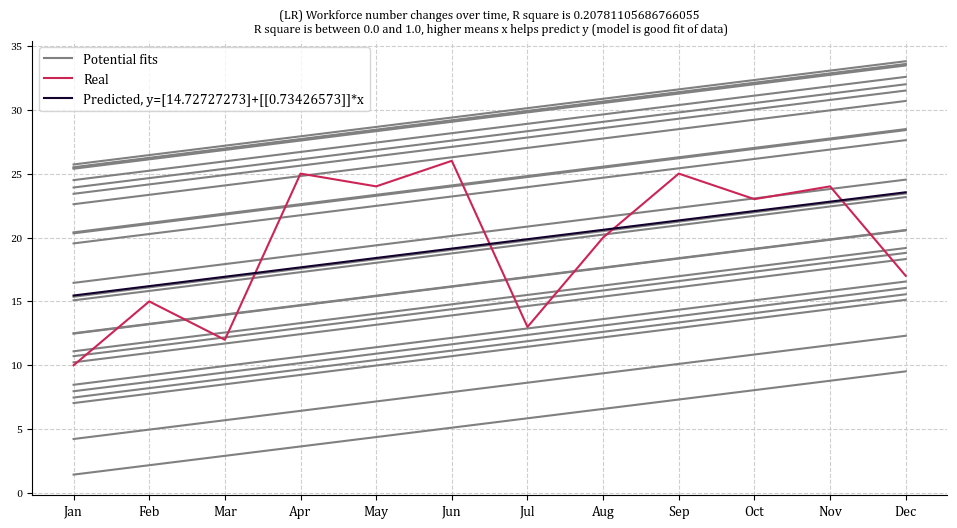

In [10]:
linear_regression_estimates(x=wkfrce['months'],y1=wkfrce['nbrs'],y2=wkfrce['preds'],
                             epochs=25,xlab="Months",ylab="Numbers",
                             title=f"(LR) Workforce number changes over time, R square is {r_sq}\n R square is between 0.0 and 1.0, higher means x helps predict y (model is good fit of data)",
                             predlab=f"Predicted, y={mod_int}+{mod_slope}*x")

# Logistic Regression

Fit a model and get predictions. A logistic regression model is of the form f = c+x1c1+x2c2 where the probabilities are p=1/(e-(a+bx)+1)

In [11]:
# fit a logistic regression model
#model = LogisticRegression().fit(x_arr,np.ravel(y_arr))
#model = LogisticRegression().fit(x_arr,y_arr.reshape(-1,1)) # y needs to be horizontal array format (1-d)

model = LogisticRegression().fit(x_arr,y_arr.reshape(-1)) # y needs to be horizontal array format (1-d)

# or can try more iterations
model = LogisticRegression(solver='lbfgs', max_iter=500).fit(x_arr,y_arr.reshape(-1)) # y needs to be horizontal array format (1-d)

r_sq = model.score(x_arr, y_arr) # model acccuracy, e.g. is x a good predictor of y for this model with its parameters
mod_int = model.intercept_
mod_slope = model.coef_
print(f"coefficient of determination: {r_sq}")

print(f"intercept: {model.intercept_}"+" this means when x = 0 the predicted y-value is this amount")

print(f"slope: {model.coef_}"+" this means the predicted y-value rises by this amount with each change in x")

# predict y-values
y_pred = model.predict(x_arr)

# put these predictions of the wkfrce df
wkfrce['preds'] = y_pred

# find the difference between the predictions and the actuals
wkfrce['var'] = wkfrce['preds'] - wkfrce['nbrs']

coefficient of determination: 0.25
intercept: [ 4.42225558  2.91217565  0.0746999   3.63521648 -8.65453913 -0.81438635
 -3.3250526  -0.23801236  1.14216214  0.8454807 ] this means when x = 0 the predicted y-value is this amount
slope: [[-1.03281159]
 [-0.45840462]
 [ 0.10992998]
 [-0.6952879 ]
 [ 1.03493774]
 [ 0.23109573]
 [ 0.52017632]
 [ 0.24606876]
 [ 0.05388917]
 [-0.00959358]] this means the predicted y-value rises by this amount with each change in x


Check and test model predictions

In [12]:
# get the MAPE
logr_mape1 = mape_value(wkfrce['nbrs'],wkfrce['preds'])
logr_mape = mean_absolute_percentage_error(wkfrce['nbrs'],wkfrce['preds'])*100

# get the MAE
logr_mae1 = mae(wkfrce['nbrs'],wkfrce['preds'])
logr_mae = mean_absolute_error(wkfrce['nbrs'],wkfrce['preds'])

# get the MSE
logr_mse1 = mse(wkfrce['nbrs'],wkfrce['preds'])
logr_mse = mean_squared_error(wkfrce['nbrs'],wkfrce['preds'])

# get the RMSE
logr_rmse1 = rmse(wkfrce['nbrs'],wkfrce['preds'])
logr_rmse = mean_squared_error(wkfrce['nbrs'],wkfrce['preds'], squared = False)

Plot the data

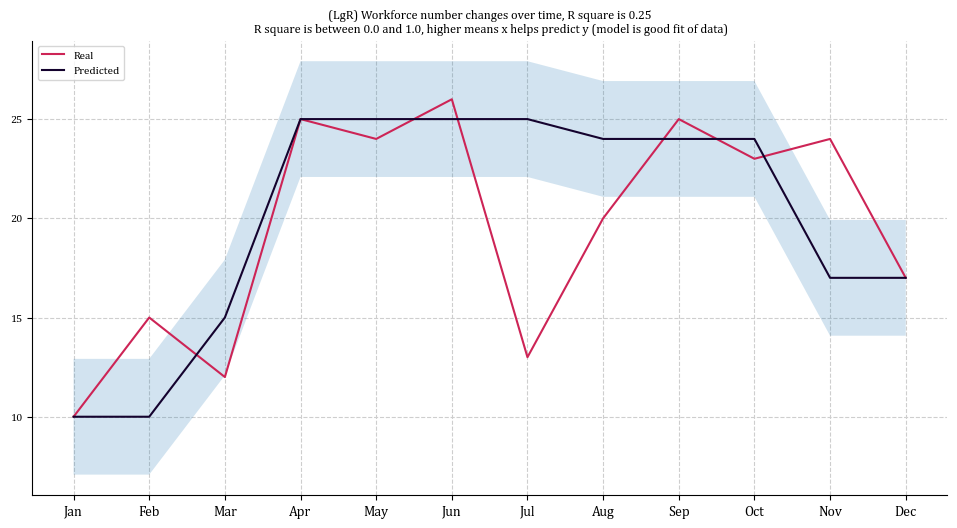

In [13]:
train_test_graph_error_lines(x=wkfrce['months'],y1=wkfrce['nbrs'],y2=wkfrce['preds'],
                             mae=(logr_mae),xlab="Months",ylab="Numbers",
                             title=f"(LgR) Workforce number changes over time, R square is {r_sq}\n R square is between 0.0 and 1.0, higher means x helps predict y (model is good fit of data)",
                             predlab=f"Predicted")

# Polynominal Regression

Fit a model and get predictions. A polynominal regression model is of the form y=c0+c1x+c2x^2...+cnx^n where n is the degrees specified

In [14]:
# set degree as number of polynomial regression function
degree_num = 5

# transform the x data
transformer = PolynomialFeatures(degree=degree_num, include_bias=False)

transformer.fit(x_arr)

x_ = transformer.transform(x_arr)

# or

x_ = PolynomialFeatures(degree=degree_num, include_bias=False).fit_transform(x_arr)

# fit a linear regression model
model = LinearRegression().fit(x_, y_arr)

r_sq = model.score(x_, y_arr) # is x a good predictor of y for this model with its parameters
mod_int = model.intercept_
mod_slope = model.coef_
print(f"coefficient of determination: {r_sq}")

print(f"intercept: {model.intercept_}"+" this means when x = 0 the predicted y-value is this amount")

print(f"slope: {model.coef_}"+" this means the predicted y-value rises by this amount with each change in x")

# predict y-values
y_pred = model.predict(x_)

# put these predictions of the wkfrce df
wkfrce['preds'] = y_pred

# find the difference between the predictions and the actuals
wkfrce['var'] = wkfrce['preds'] - wkfrce['nbrs']

coefficient of determination: 0.6337616323742862
intercept: [23.18181818] this means when x = 0 the predicted y-value is this amount
slope: [[-2.43181441e+01  1.45015597e+01 -3.09254165e+00  2.78109146e-01
  -8.94607843e-03]] this means the predicted y-value rises by this amount with each change in x


Check and test model predictions

In [15]:
# get the MAPE
pr_mape1 = mape_value(wkfrce['nbrs'],wkfrce['preds'])
pr_mape = mean_absolute_percentage_error(wkfrce['nbrs'],wkfrce['preds'])*100

# get the MAE
pr_mae1 = mae(wkfrce['nbrs'],wkfrce['preds'])
pr_mae = mean_absolute_error(wkfrce['nbrs'],wkfrce['preds'])

# get the MSE
pr_mse1 = mse(wkfrce['nbrs'],wkfrce['preds'])
pr_mse = mean_squared_error(wkfrce['nbrs'],wkfrce['preds'])

# get the RMSE
pr_rmse1 = rmse(wkfrce['nbrs'],wkfrce['preds'])
pr_rmse = mean_squared_error(wkfrce['nbrs'],wkfrce['preds'], squared = False)

Plot the data

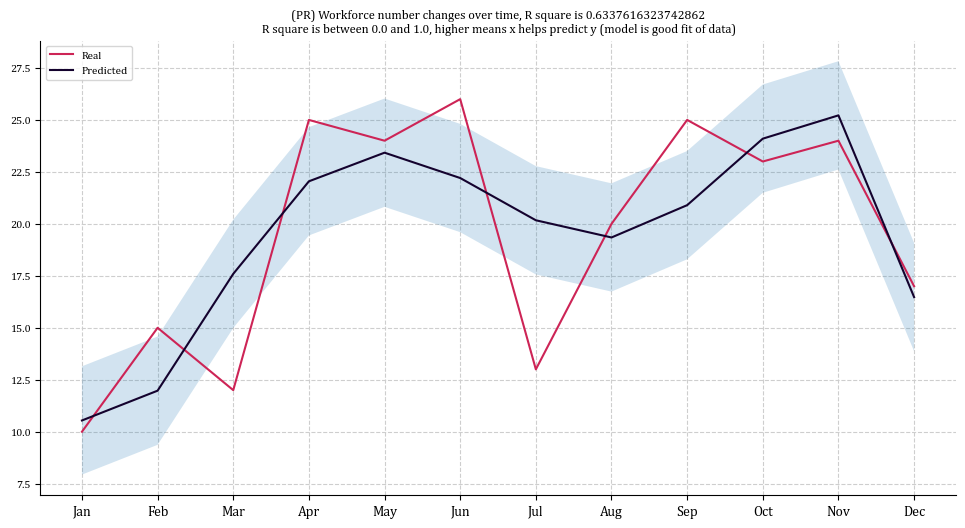

In [16]:
train_test_graph_error_lines(x=wkfrce['months'],y1=wkfrce['nbrs'],y2=wkfrce['preds'],
                             mae=(pr_mae),xlab="Months",ylab="Numbers",
                             title=f"(PR) Workforce number changes over time, R square is {r_sq}\n R square is between 0.0 and 1.0, higher means x helps predict y (model is good fit of data)",
                             predlab=f"Predicted")

# Check how well the model(s) fit the data

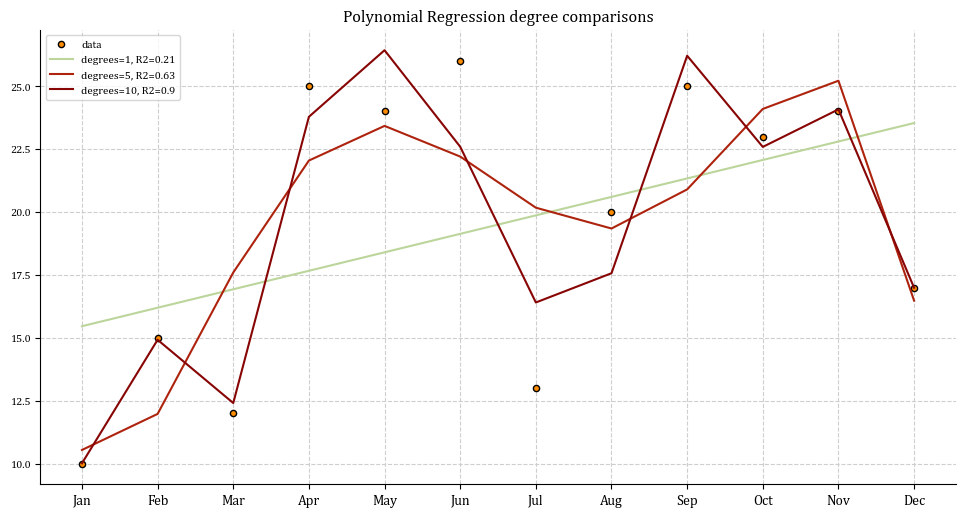

In [17]:
# make some variable models for depth_plot tests

degree_nums = [1,5,10]

x_1 = PolynomialFeatures(degree=degree_nums[0], include_bias=False).fit_transform(x_arr)
x_2 = PolynomialFeatures(degree=degree_nums[1], include_bias=False).fit_transform(x_arr)
x_3 = PolynomialFeatures(degree=degree_nums[2], include_bias=False).fit_transform(x_arr)

model1 = LinearRegression().fit(x_1, y_arr)
model2 = LinearRegression().fit(x_2, y_arr)
model3 = LinearRegression().fit(x_3, y_arr)

r_sq1 = model1.score(x_1, y_arr)
r_sq2 = model2.score(x_2, y_arr)
r_sq3 = model3.score(x_3, y_arr)

y_pred1 = model1.predict(x_1)
y_pred2 = model2.predict(x_2)
y_pred3 = model3.predict(x_3)

yvalues = [y_pred1, y_pred2, y_pred3]
labelvalues = [f"degrees={degree_nums[0]}, R2={round(r_sq1,2)}",
               f"degrees={degree_nums[1]}, R2={round(r_sq2,2)}",
               f"degrees={degree_nums[2]}, R2={round(r_sq3,2)}"]

depth_plot(x=wkfrce['months'],y=wkfrce['nbrs'],yvals=yvalues,labels=labelvalues,title="Polynomial Regression degree comparisons")


# Decision Tree Regressor

A decision tree follows as many steps as specified (or needed) to predict values. It is comprised of a root node (the first decision box) which is also a split node. There is then a child node (split node) which can ask questions e.g. yes or no. Any decision or result which does not have a following node is considered a leaf node (it does not have any child nodes).

Fit, build the model, and graph it.

coefficient of determination: 1.0


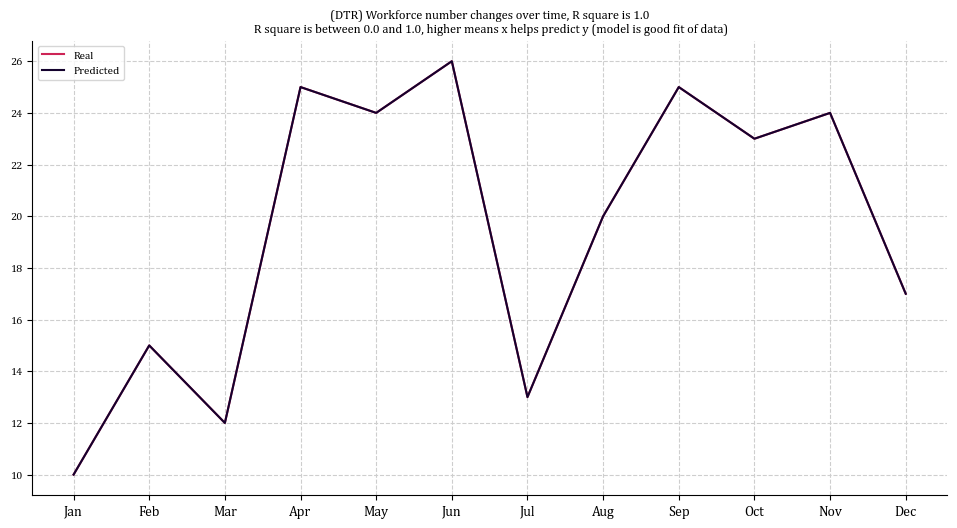

In [18]:
model = DecisionTreeRegressor().fit(x_arr,y_arr)

r_sq = model.score(x_arr, y_arr) # model acccuracy, e.g. is x a good predictor of y for this model with its parameters

print(f"coefficient of determination: {r_sq}")

# predict y-values
y_pred = model.predict(x_arr)

# put these predictions of the wkfrce df
wkfrce['preds'] = y_pred

# find the difference between the predictions and the actuals
wkfrce['var'] = wkfrce['preds'] - wkfrce['nbrs']

# get the MAPE
dtr_mape1 = mape_value(wkfrce['nbrs'],wkfrce['preds'])
dtr_mape = mean_absolute_percentage_error(wkfrce['nbrs'],wkfrce['preds'])*100

# get the MAE
dtr_mae1 = mae(wkfrce['nbrs'],wkfrce['preds'])
dtr_mae = mean_absolute_error(wkfrce['nbrs'],wkfrce['preds'])

# get the MSE
dtr_mse1 = mse(wkfrce['nbrs'],wkfrce['preds'])
dtr_mse = mean_squared_error(wkfrce['nbrs'],wkfrce['preds'])

# get the RMSE
dtr_rmse1 = rmse(wkfrce['nbrs'],wkfrce['preds'])
dtr_rmse = mean_squared_error(wkfrce['nbrs'],wkfrce['preds'], squared = False)

# graph this
train_test_graph_error_lines(x=wkfrce['months'],y1=wkfrce['nbrs'],y2=wkfrce['preds'],
                             mae=(dtr_mae),xlab="Months",ylab="Numbers",
                             title=f"(DTR) Workforce number changes over time, R square is {r_sq}\n R square is between 0.0 and 1.0, higher means x helps predict y (model is good fit of data)",
                             predlab="Predicted")

View the decisions(s) made to generate predictions

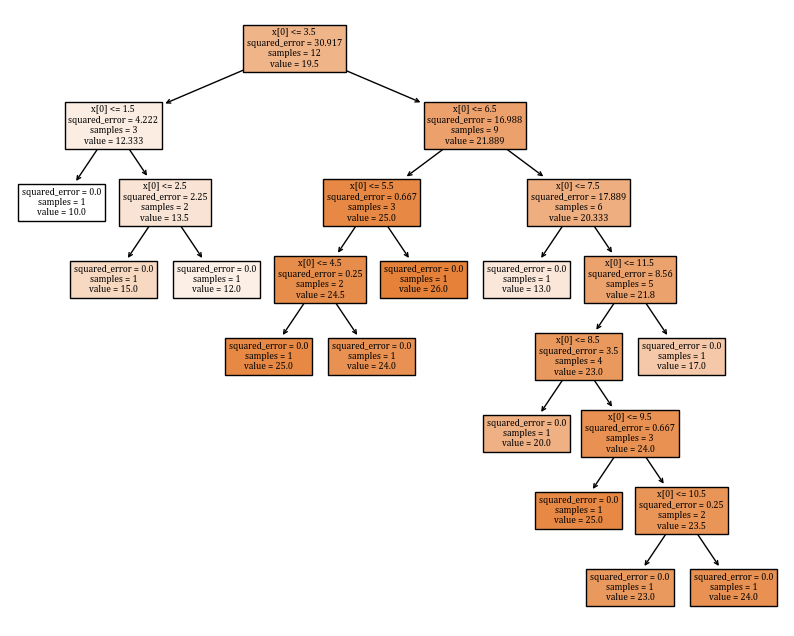

In [19]:
plt.figure(figsize=(10,8))
plot_tree(model, filled=True);

Compare the model fitting to the data based on different parameters

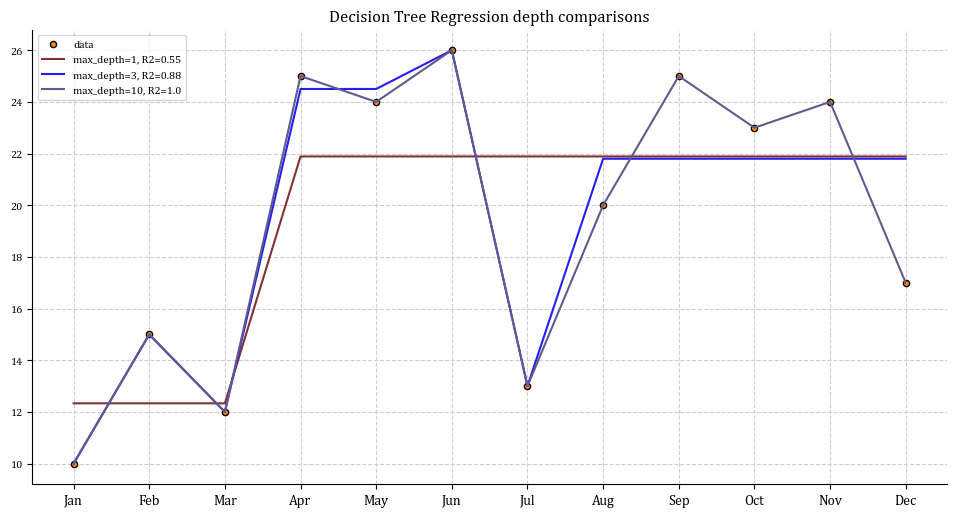

In [20]:
# depths
depthvalues = [1,3,10]

# we can check if we have overfitted the data by checking random tree depth
regr_1 = DecisionTreeRegressor(max_depth=depthvalues[0]).fit(x_arr,y_arr)
regr_2 = DecisionTreeRegressor(max_depth=depthvalues[1]).fit(x_arr,y_arr)
regr_3 = DecisionTreeRegressor(max_depth=depthvalues[2]).fit(x_arr,y_arr)

r_sq1 = regr_1.score(x_arr, y_arr)
r_sq2 = regr_2.score(x_arr, y_arr)
r_sq3 = regr_3.score(x_arr, y_arr)

# predict these new values
y_1 = regr_1.predict(x_arr)
y_2 = regr_2.predict(x_arr)
y_3 = regr_3.predict(x_arr)

yvalues = [y_1,y_2,y_3]
labelvalues = [f"max_depth={depthvalues[0]}, R2={round(r_sq1,2)}",
               f"max_depth={depthvalues[1]}, R2={round(r_sq2,2)}",
               f"max_depth={depthvalues[2]}, R2={round(r_sq3,2)}"]

depth_plot(x=wkfrce['months'],y=wkfrce['nbrs'],yvals=yvalues,labels=labelvalues,title="Decision Tree Regression depth comparisons")

# Classification of data

In [21]:
# make categorical data, 1 if +ve change and 0 if not +ve change
wkfrce['category'] = wkfrce['change'].apply(lambda x: "joiners" if x > 0 else "leavers")

# e.g. the aim here is for a model to classify "joiners" and "leavers" from the data

class_names = sorted(pd.Series(wkfrce['category']).drop_duplicates().tolist())
class_names = sorted(wkfrce['category'].unique().tolist())

# Random Forest Classifier

A random forest is a model comprised of many (ensemble) decision trees, usually trained with the bagging method. The random forest method adds extra randomness when growing decision trees and this results in greater algorithm diversity. When growing a tree in a random forest, at each node a random subset of features is considered for splitting.

In [22]:
#random_forest_classifier = RandomForestClassifier(random_state=0)
random_forest_classifier = RandomForestClassifier(random_state=0, n_estimators=5, max_depth=5)
random_forest_classifier.fit(wkfrce[['xvals','nbrs']],wkfrce['category_vals'])
acca = random_forest_classifier.score(wkfrce[['xvals','nbrs']],wkfrce['category_vals']) # model acccuracy, e.g. is x a good predictor of y for this model with its parameters
print(acca)

0.75


Plot the model

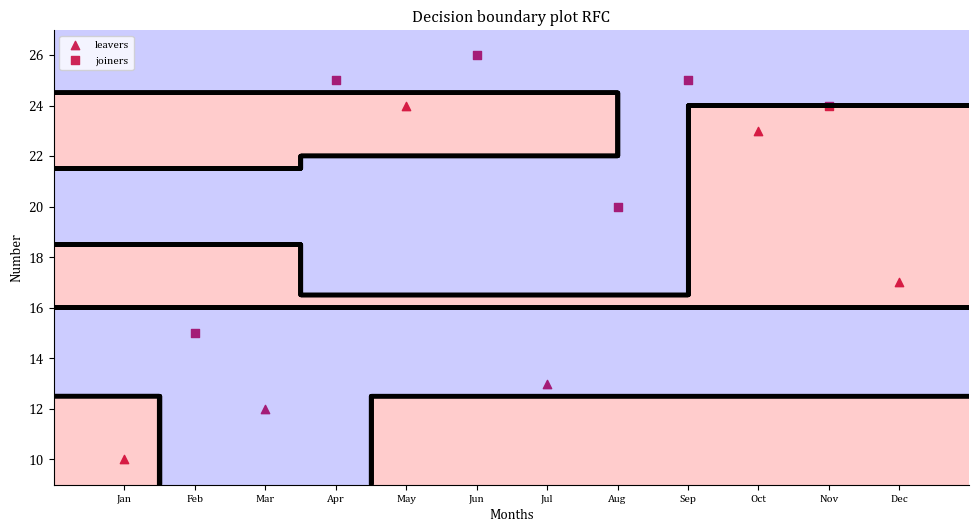

In [23]:
plot_model(wkfrce[['xvals', 'nbrs']], wkfrce['category_vals'], random_forest_classifier, "RFC")

View the prediction ROC

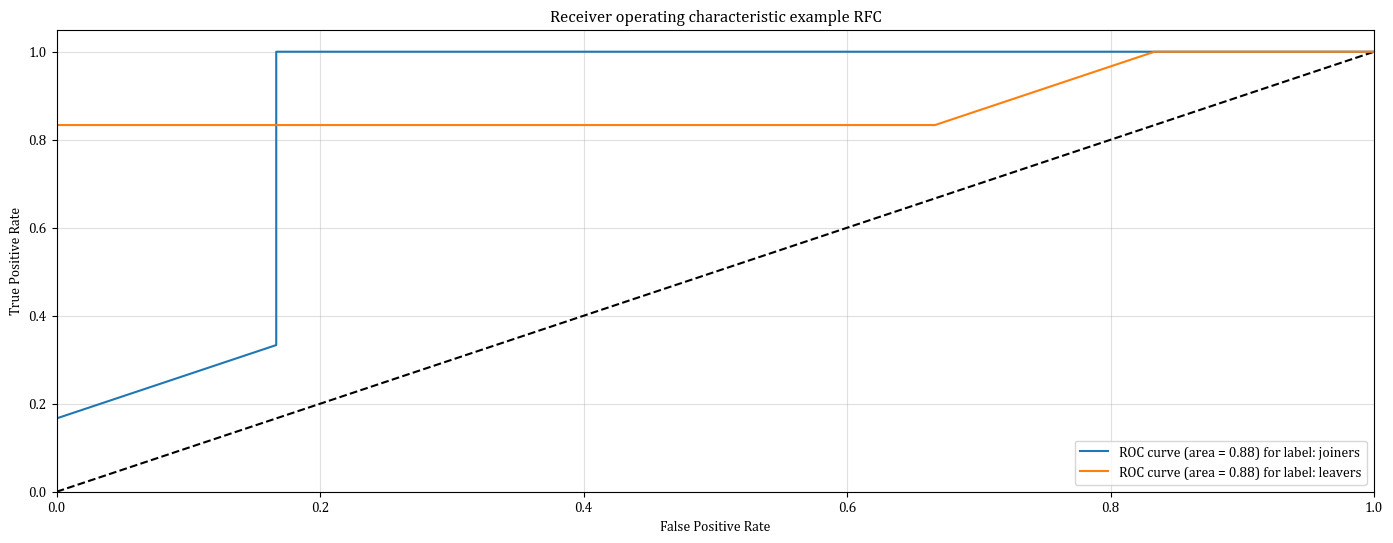

In [24]:
plot_multiclass_roc(random_forest_classifier, wkfrce[['xvals', 'nbrs']], wkfrce['category_vals'], len(class_names), "RFC")

An ROC curve is a receiver operating characteristic curve, and what this aims to show is how well a model predicts true true (and false true) values. 

The dashed diagonal line shows, in effect, the results of random guessing.

The sensitivity (or true positive rate (tpr), also known as recall) show how accurately the model predicts true values (a perfect classifier would have a single entry on the graph in the top-left corner – it would be 100% accurate).

The specificity, or false positive rate (fpr) or fall-out is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 – the true negative rate (tnr), which is the ratio of negative instances that are correctly classified as negative. The tnr is also called specificity, hence the roc curve plots sensitivity (recall) versus 1 – specificity.

# Get feature importance from RFC

In [25]:
for score, name in zip(random_forest_classifier.feature_importances_, wkfrce.columns):
    print(round(score, 2), name)

0.31 nbrs
0.69 months


# Decision Tree Classifier and Bagging

A bagging model (Decision Tree Classifier) is essentially the same thing as a Random Forest Classifier.

The Decision Tree Classifier, and Bagging model results are compared below.

In [26]:
dtc = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, n_jobs=-1, random_state=42)

dtc.fit(wkfrce[['xvals','nbrs']],wkfrce['category_vals'])
acca = dtc.score(wkfrce[['xvals','nbrs']],wkfrce['category_vals']) # model acccuracy, e.g. is x a good predictor of y for this model with its parameters
print(acca)

bag.fit(wkfrce[['xvals','nbrs']],wkfrce['category_vals'])
acca1 = bag.score(wkfrce[['xvals','nbrs']],wkfrce['category_vals']) # model acccuracy, e.g. is x a good predictor of y for this model with its parameters
print(acca1)

1.0
1.0


Compare the models

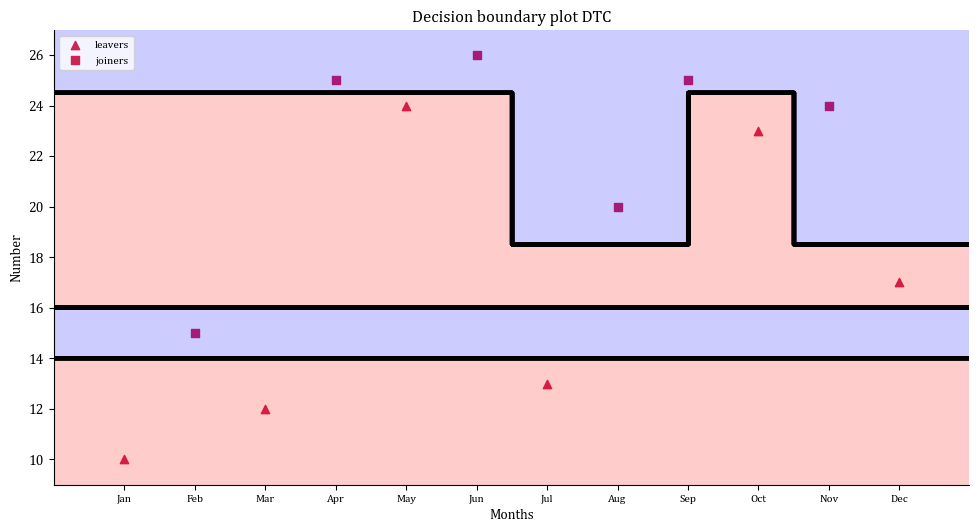

In [27]:
plot_model(wkfrce[['xvals', 'nbrs']], wkfrce['category_vals'], dtc, "DTC")

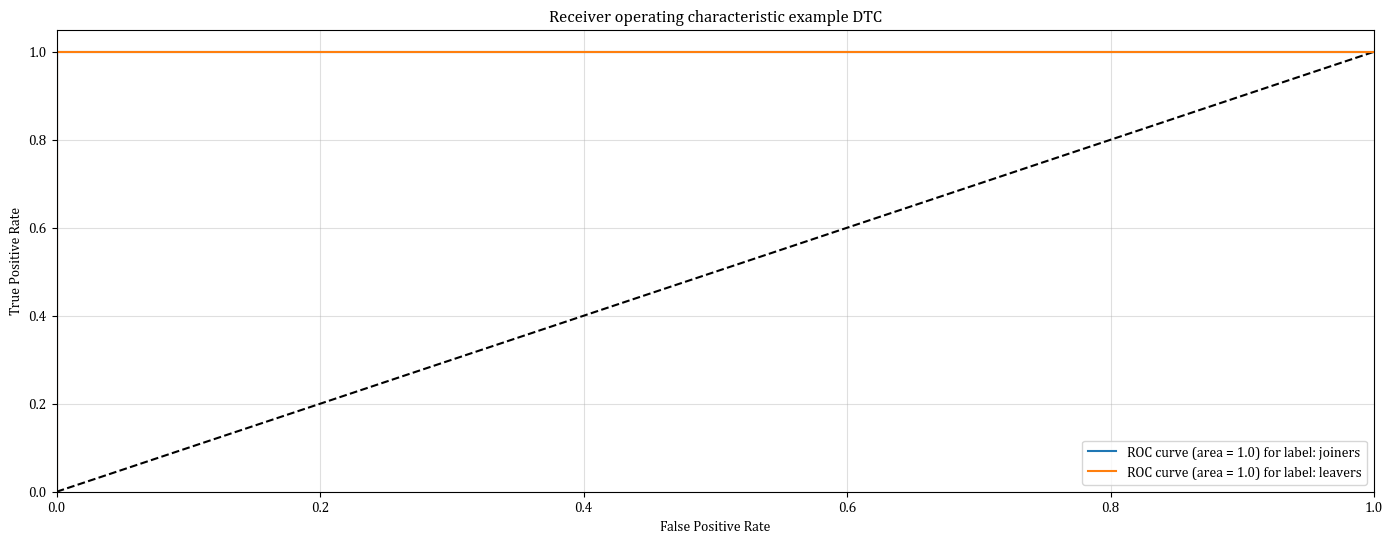

In [28]:
plot_multiclass_roc(dtc, wkfrce[['xvals', 'nbrs']], wkfrce['category_vals'], len(class_names), "DTC")

# Get feature importance from DTC

In [29]:
for score, name in zip(dtc.feature_importances_, wkfrce.columns):
    print(round(score, 2), name)

0.29 nbrs
0.71 months


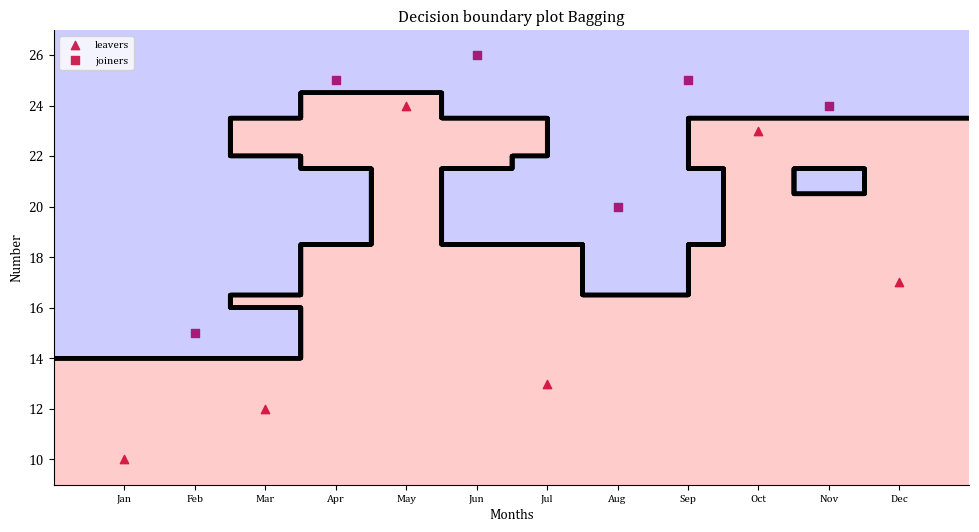

In [30]:
plot_model(wkfrce[['xvals', 'nbrs']], wkfrce['category_vals'], bag, "Bagging")

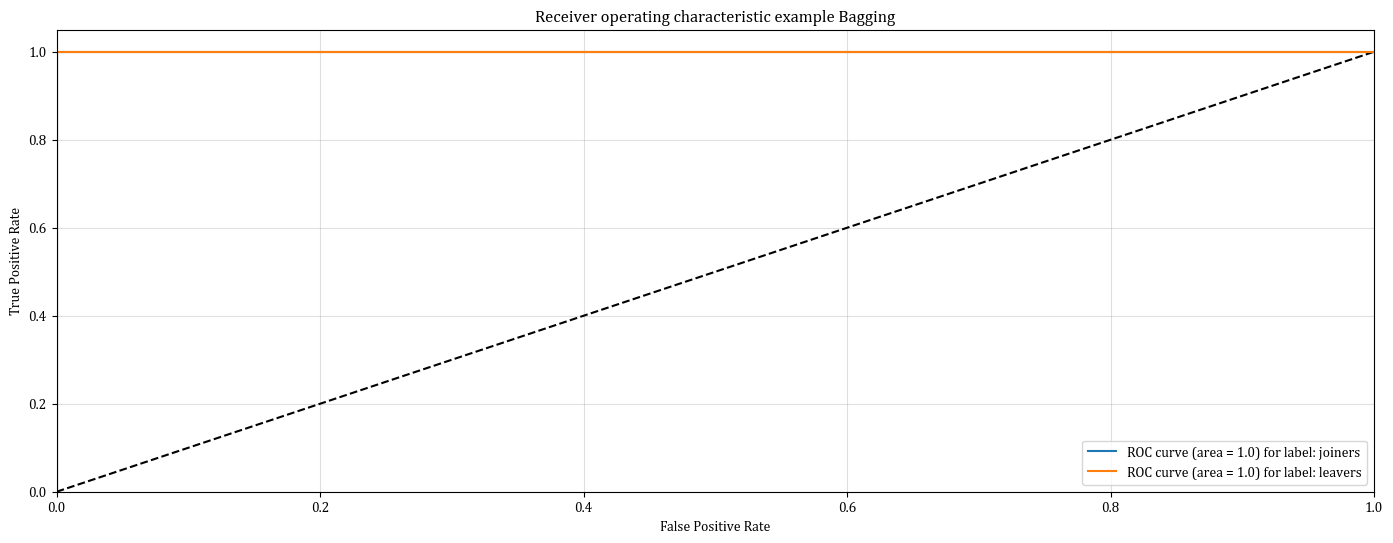

In [31]:
plot_multiclass_roc(bag, wkfrce[['xvals', 'nbrs']], wkfrce['category_vals'], len(class_names), "Bagging")

# AdaBoost Classifier

In [32]:
ada = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30, learning_rate=0.5, random_state=42)

ada.fit(wkfrce[['xvals','nbrs']],wkfrce['category_vals'])
acca = ada.score(wkfrce[['xvals','nbrs']],wkfrce['category_vals']) # model acccuracy, e.g. is x a good predictor of y for this model with its parameters
print(acca)

1.0


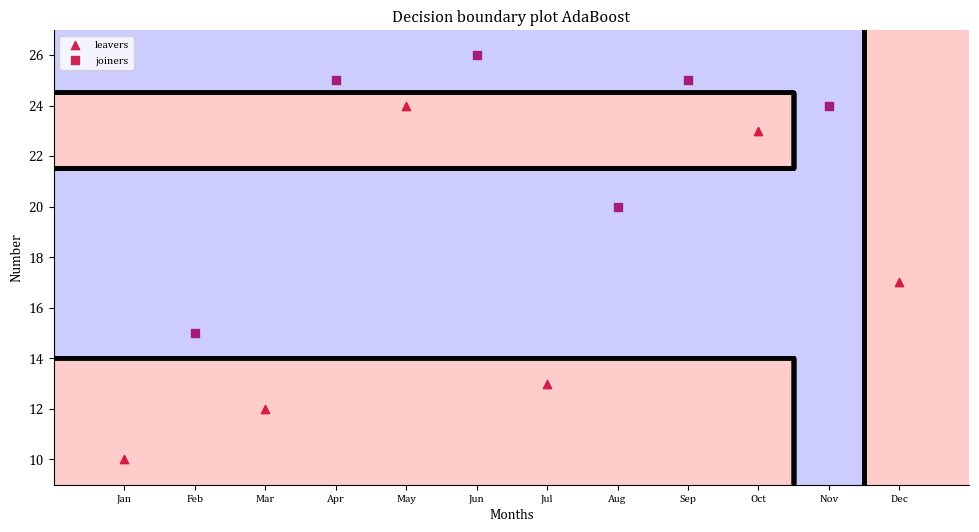

In [33]:
plot_model(wkfrce[['xvals', 'nbrs']], wkfrce['category_vals'], ada, "AdaBoost")

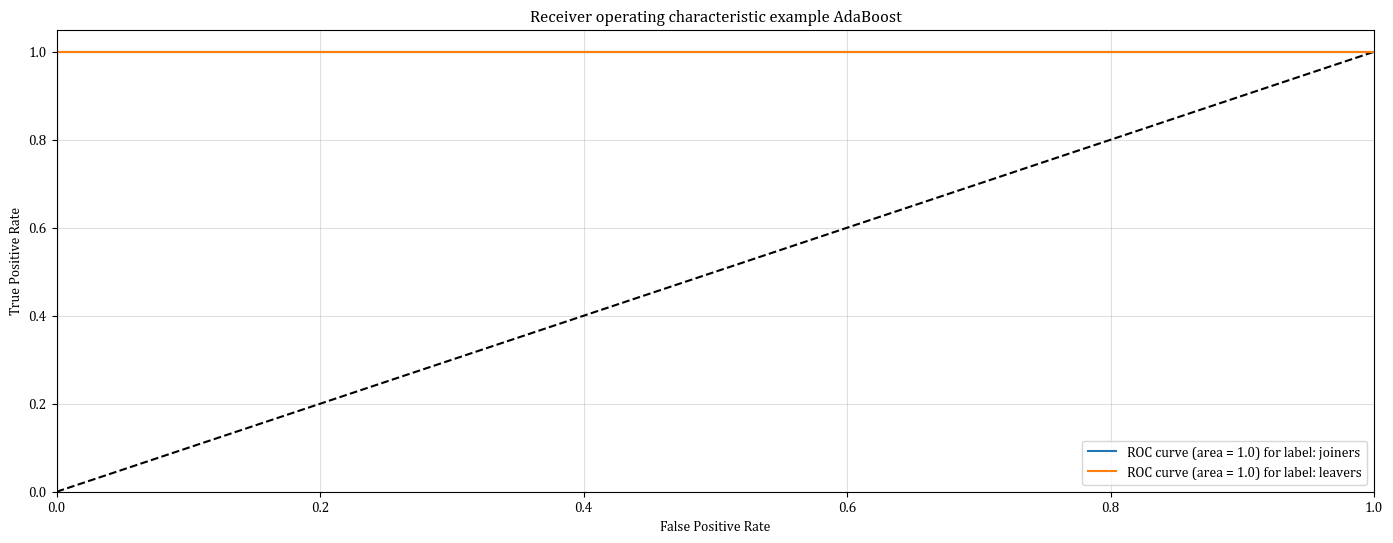

In [34]:
plot_multiclass_roc(ada, wkfrce[['xvals', 'nbrs']], wkfrce['category_vals'], len(class_names), "AdaBoost")

# Get feature importance AdaBoost - as base model is DTC

In [35]:
for score, name in zip(ada.feature_importances_, wkfrce.columns):
    print(round(score, 2), name)

0.47 nbrs
0.53 months
